**Using Deep Learning Keras**
# Net Asset Value Prediction

In [1]:
# tensorflow libs
from tensorflow.keras import models, layers, Input

#import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.stats import norm
import scipy.optimize as opt
import yfinance as yf
import pandas as pd
# Data Scaling
from sklearn.preprocessing import MinMaxScaler

# Stationary Data
from statsmodels.tsa.stattools import adfuller

# Correlation
import statsmodels.api as sm


import datetime
import time
import matplotlib.pyplot as plt


from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
# Neural Net Libs
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dense, LSTM
import warnings
warnings.filterwarnings('ignore')
import quandl
#Configuration key for Quandl from where data is accessed
quandl.ApiConfig.api_key='RZCxWTQxvxZLMAzP22Ay'

2023-06-29 16:03:22.196658: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#Data Understanding
stocks = '^GSPC'
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2022, 12, 1)
s_p500 = yf.download(stocks, start=start, end = end, interval='1d')

s_p500.info()

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3251 entries, 2010-01-04 to 2022-11-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3251 non-null   float64
 1   High       3251 non-null   float64
 2   Low        3251 non-null   float64
 3   Close      3251 non-null   float64
 4   Adj Close  3251 non-null   float64
 5   Volume     3251 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 177.8 KB


In [45]:
import quandl

quandl.ApiConfig.api_key = 'YOUR_API_KEY'  # Replace with your Quandl API key

# For sample case, start_date and end_date are pre-defined
database_code = 'EOD'
dataset_code = 'SPY'
start_date = '2019-07-03'
end_date = '2019-07-03'

try:
    limited_dt = quandl.get(f'{database_code}/{dataset_code}', start_date=start_date, end_date=end_date)
    print("LIVE API DATA...")
    print(limited_dt)
    print()

    yr = int(input("Enter year span (non-zero): "))
    if yr == 0:
        raise ValueError("Year span cannot be zero.")

    print("Displaying the expected return...")

    # Applying hypothetical formula on the extracted values
    retur = limited_dt['Net Asset Value'][0] + limited_dt['Net Asset Value'][0] * 0.1 / yr

    # Printing the final result
    print(retur)

except Exception as e:
    print(f"An error occurred: {str(e)}")


An error occurred: (Status 429) (Quandl Error QELx06) You have exceeded the API speed limit and your account has temporaly been disabled.  Please contact clientsuccess@nasdaq.com for more information.


In [14]:
s_p500.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,1116.560059,1133.869995,1116.560059,1132.989990,1132.989990,3991400000
2010-01-05,1132.660034,1136.630005,1129.660034,1136.520020,1136.520020,2491020000
2010-01-06,1135.709961,1139.189941,1133.949951,1137.140015,1137.140015,4972660000
2010-01-07,1136.270020,1142.459961,1131.319946,1141.689941,1141.689941,5270680000
2010-01-08,1140.520020,1145.390015,1136.219971,1144.979980,1144.979980,4389590000


In [16]:
df_sp500 = s_p500[['Adj Close']]
df_sp500.reset_index(inplace=True)
df_sp500.columns = ['date', 'returns']
df_sp500[df_sp500['returns'] == '.'].shape
df_sp500['returns'] = pd.to_numeric(df_sp500['returns'], errors='coerce')
df_sp500['date'] = pd.to_datetime(df_sp500['date']).dt.date
df_sp500.set_index('date', inplace=True)

df_sp500.head()

,returns
date,
2010-01-04,1132.989990
2010-01-05,1136.520020
2010-01-06,1137.140015
2010-01-07,1141.689941
2010-01-08,1144.979980


In [19]:
#Data Analysis
roll_avg_10 = df_sp500.returns.rolling(window=10).mean()
roll_avg_30 = df_sp500.returns.rolling(window=30).mean()
roll_avg_70 = df_sp500.returns.rolling(window=70).mean()

[Text(0.5, 0, 'Year'), Text(0, 0.5, 'S&P 500')]

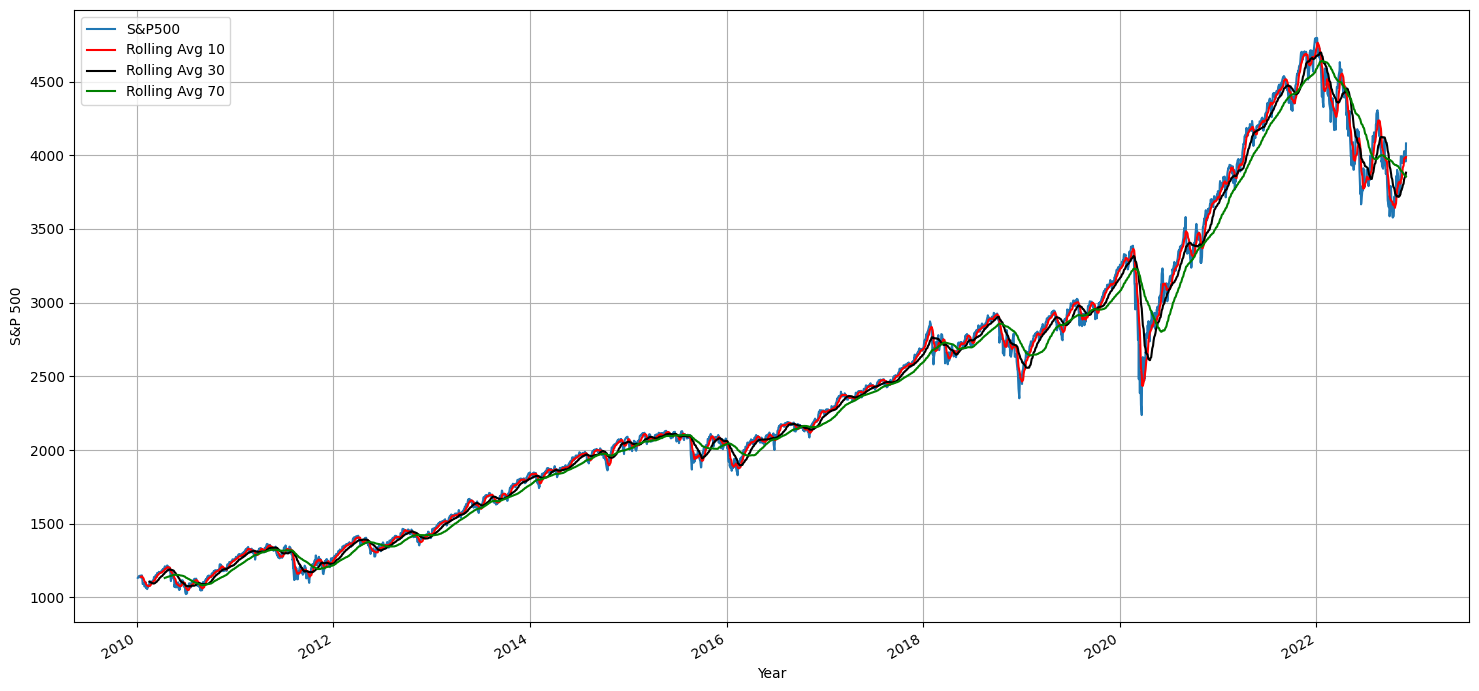

In [20]:
fig, ax = plt.subplots(figsize=(18, 9))
fig.autofmt_xdate()
ax.plot(df_sp500.returns, label='S&P500', color='tab:blue')
ax.plot(roll_avg_10, label='Rolling Avg 10', color='r')
ax.plot(roll_avg_30, label='Rolling Avg 30', color='k')
ax.plot(roll_avg_70, label='Rolling Avg 70', color='g')
ax.legend()
ax.grid()
ax.set(xlabel='Year',ylabel='S&P 500')

In [21]:
# Stationary Data

def check_stationarity(timeseries):
    result = adfuller(timeseries,autolag='AIC')
    dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    print('The test statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('%s: %.3f' % (key, value))

In [22]:
check_stationarity(df_sp500.returns)

The test statistic: -0.340017
p-value: 0.919642
Critical Values:
1%: -3.432
5%: -2.862
10%: -2.567


The value of test statistics is more than 5% critical value and p-value is also more than 0.05 so we can not accept Alternate Hypothesis at this significance level. The time series is non stationary

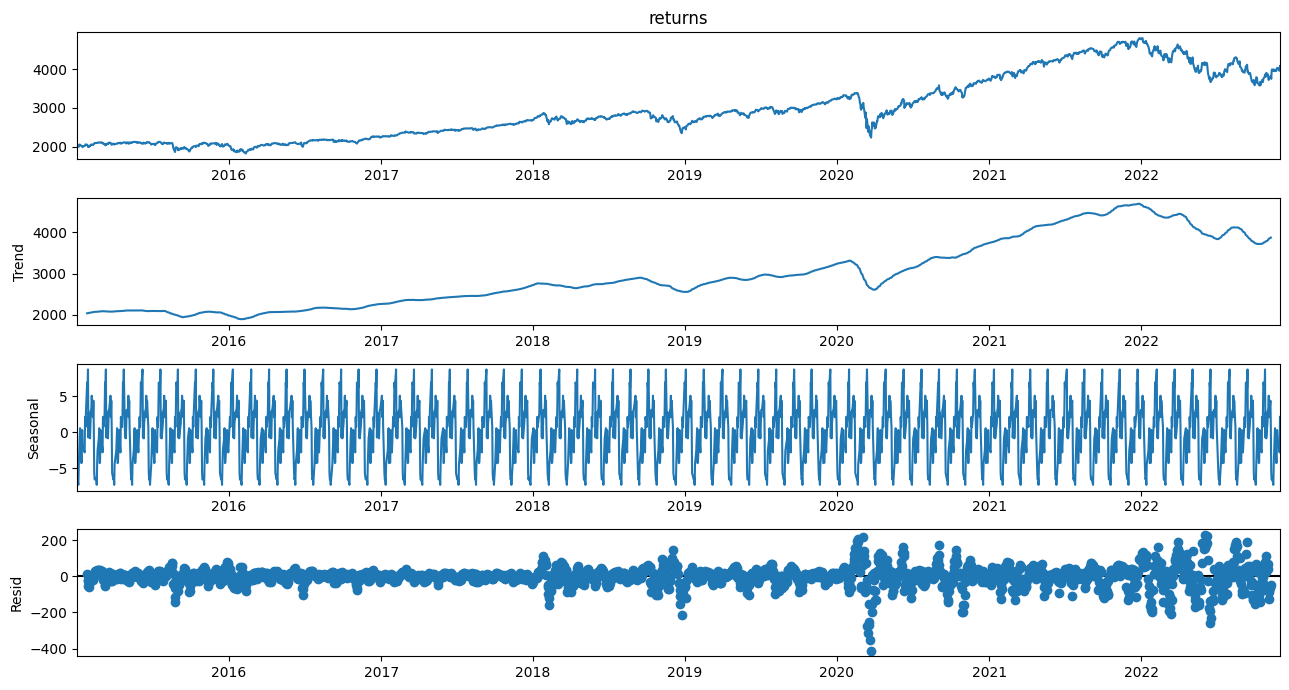

In [44]:
import statsmodels.api as sm

df_sample = df_sp500[(df_sp500.index > datetime.date(2015, 1, 1))]
decomposition = sm.tsa.seasonal_decompose(df_sample['returns'], model='additive', period=30)
plt.rcParams["figure.figsize"] = [13, 7]
fig = decomposition.plot()


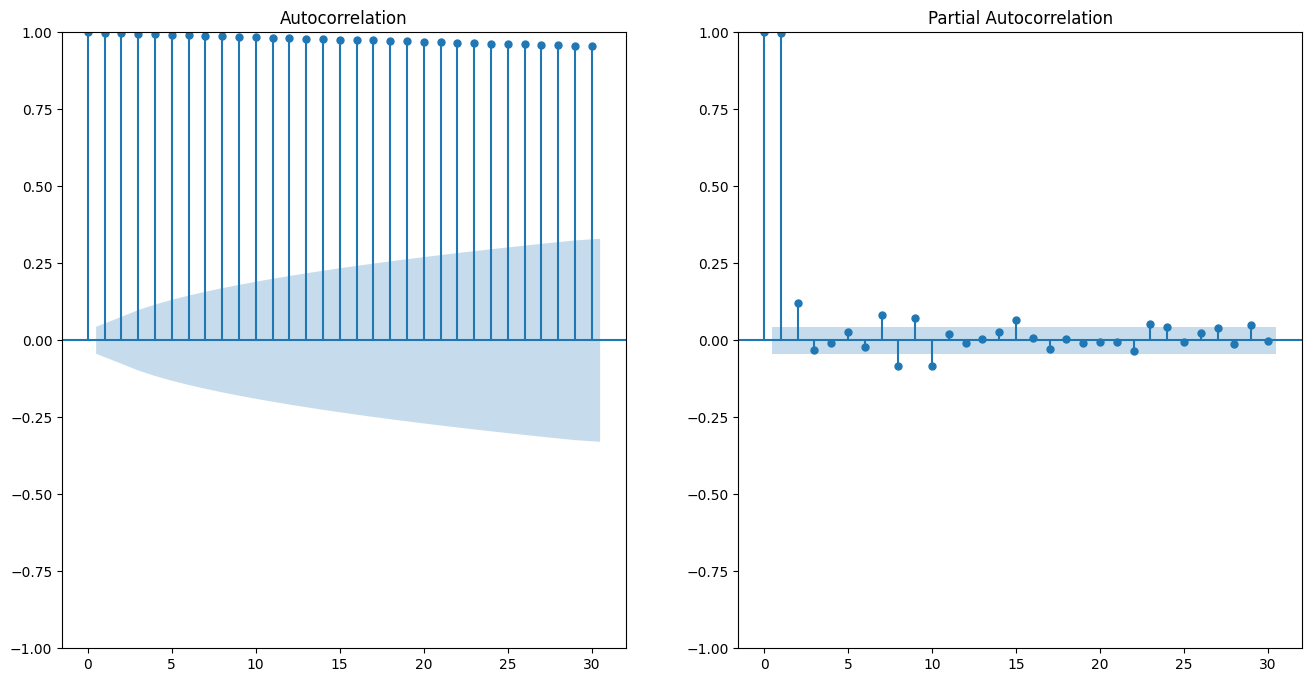

In [26]:
# Graph data
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

fig = sm.graphics.tsa.plot_acf(df_sample.iloc[1:]['returns'], lags=30, ax=axes[0])
fig = sm.graphics.tsa.plot_pacf(df_sample.iloc[1:]['returns'], lags=30, ax=axes[1])

In [27]:
#Data Preparation
scaler = MinMaxScaler()
scaled_df = df_sp500.returns.values.reshape(df_sp500.returns.shape[0], 1)
scaled_df = scaler.fit_transform(scaled_df)


In [28]:
scaled_df

array([[0.02925558],
       [0.03019094],
       [0.03035522],
       ...,
       [0.77937877],
       [0.77770678],
       [0.81016064]])

In [29]:
def preprocess(df, look_back):
    X, y = [], []
    for i in range(look_back, len(df)):
        X.append(df[i-look_back:i,0])
        y.append(df[i,0])
    return np.array(X),np.array(y)

In [30]:
look_back = 60
X, y = preprocess(scaled_df, look_back)

In [31]:
X

array([[0.02925558, 0.03019094, 0.03035522, ..., 0.03815864, 0.03991541,
        0.03992867],
       [0.03019094, 0.03035522, 0.03156083, ..., 0.03991541, 0.03992867,
        0.03891119],
       [0.03035522, 0.03156083, 0.03243259, ..., 0.03992867, 0.03891119,
        0.04120847],
       ...,
       [0.78014988, 0.76886469, 0.76460657, ..., 0.78988231, 0.79615683,
        0.79585479],
       [0.76886469, 0.76460657, 0.78359983, ..., 0.79615683, 0.79585479,
        0.77937877],
       [0.76460657, 0.78359983, 0.7905712 , ..., 0.79585479, 0.77937877,
        0.77770678]])

In [32]:
X_train,X_test = X[:int(X.shape[0]*0.90)],X[int(X.shape[0]*0.90):]
y_train,y_test = y[:int(y.shape[0]*0.90)],y[int(y.shape[0]*0.90):]
print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

2871
320
2871
320


In [33]:
X_train = X_train.reshape((X_train.shape[0],1, 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, 1, X_test.shape[1]))
print(X_train.shape, X_test.shape)

(2871, 1, 1, 60) (320, 1, 1, 60)


In [34]:
# Data Modeling
model = models.Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, 1, 60)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2, padding='same')))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 1, 64)      3904      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 1, 64)      0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 64)         0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                        

In [35]:
history = model.fit(X_train,y_train,epochs=20, validation_data=(X_test,y_test), shuffle=True)

Epoch 1/20
90/90 [==============================] - 3s 8ms/step - loss: 0.0040 - val_loss: 0.0029
Epoch 2/20
90/90 [==============================] - 0s 3ms/step - loss: 3.5563e-04 - val_loss: 0.0018
Epoch 3/20
90/90 [==============================] - 0s 4ms/step - loss: 3.2404e-04 - val_loss: 0.0016
Epoch 4/20
90/90 [==============================] - 0s 3ms/step - loss: 2.2966e-04 - val_loss: 0.0011
Epoch 5/20
90/90 [==============================] - 0s 4ms/step - loss: 2.1530e-04 - val_loss: 0.0011
Epoch 6/20
90/90 [==============================] - 0s 3ms/step - loss: 1.6418e-04 - val_loss: 0.0010
Epoch 7/20
90/90 [==============================] - 0s 3ms/step - loss: 1.6661e-04 - val_loss: 0.0010
Epoch 8/20
90/90 [==============================] - 0s 3ms/step - loss: 2.2133e-04 - val_loss: 7.9282e-04
Epoch 9/20
90/90 [==============================] - 0s 3ms/step - loss: 1.7332e-04 - val_loss: 0.0016
Epoch 10/20
90/90 [==============================] - 0s 3ms/step - loss: 2.0464e-0

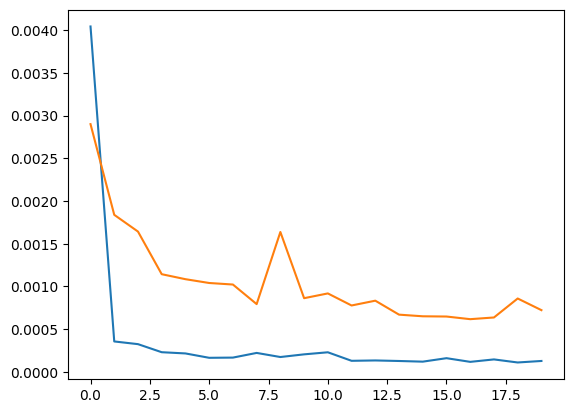

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [37]:
X_test.shape[0]


320

In [38]:
actual = []
prediction = []
for i in range(X_test.shape[0]):
  # i=274
  Xt = model.predict(X_test[i].reshape(1, 1, 1, 60))
  print('predicted:{0}, actual:{1}'.format(scaler.inverse_transform(Xt),scaler.inverse_transform(y_test[i].reshape(-1,1))))
  prediction.append(scaler.inverse_transform(Xt))
  actual.append(scaler.inverse_transform(y_test[i].reshape(-1,1)))


1/1 [==============================] - 0s 312ms/step
predicted:[[4502.571]], actual:[[4496.18994141]]
1/1 [==============================] - 0s 21ms/step
predicted:[[4523.5146]], actual:[[4470.]]
1/1 [==============================] - 0s 21ms/step
predicted:[[4526.309]], actual:[[4509.37011719]]
1/1 [==============================] - 0s 21ms/step
predicted:[[4501.9297]], actual:[[4528.79003906]]
1/1 [==============================] - 0s 27ms/step
predicted:[[4513.169]], actual:[[4522.68017578]]
1/1 [==============================] - 0s 23ms/step
predicted:[[4535.045]], actual:[[4524.08984375]]
1/1 [==============================] - 0s 21ms/step
predicted:[[4549.2954]], actual:[[4536.95019531]]
1/1 [==============================] - 0s 21ms/step
predicted:[[4549.606]], actual:[[4535.43017578]]
1/1 [==============================] - 0s 21ms/step
predicted:[[4567.7666]], actual:[[4520.02978516]]
1/1 [==============================] - 0s 22ms/step
predicted:[[4560.7524]], actual:[[4514.069

In [39]:
result_df = pd.DataFrame({'prediction':list(np.reshape(prediction, (-1))),'actual':list(np.reshape(actual, (-1)))})
result_df.head()

,prediction,actual
0,4502.570801,4496.189941
1,4523.514648,4470.000000
2,4526.309082,4509.370117
3,4501.929688,4528.790039
4,4513.168945,4522.680176


In [40]:
test_data = result_df['actual']
forecast_data = result_df['prediction']


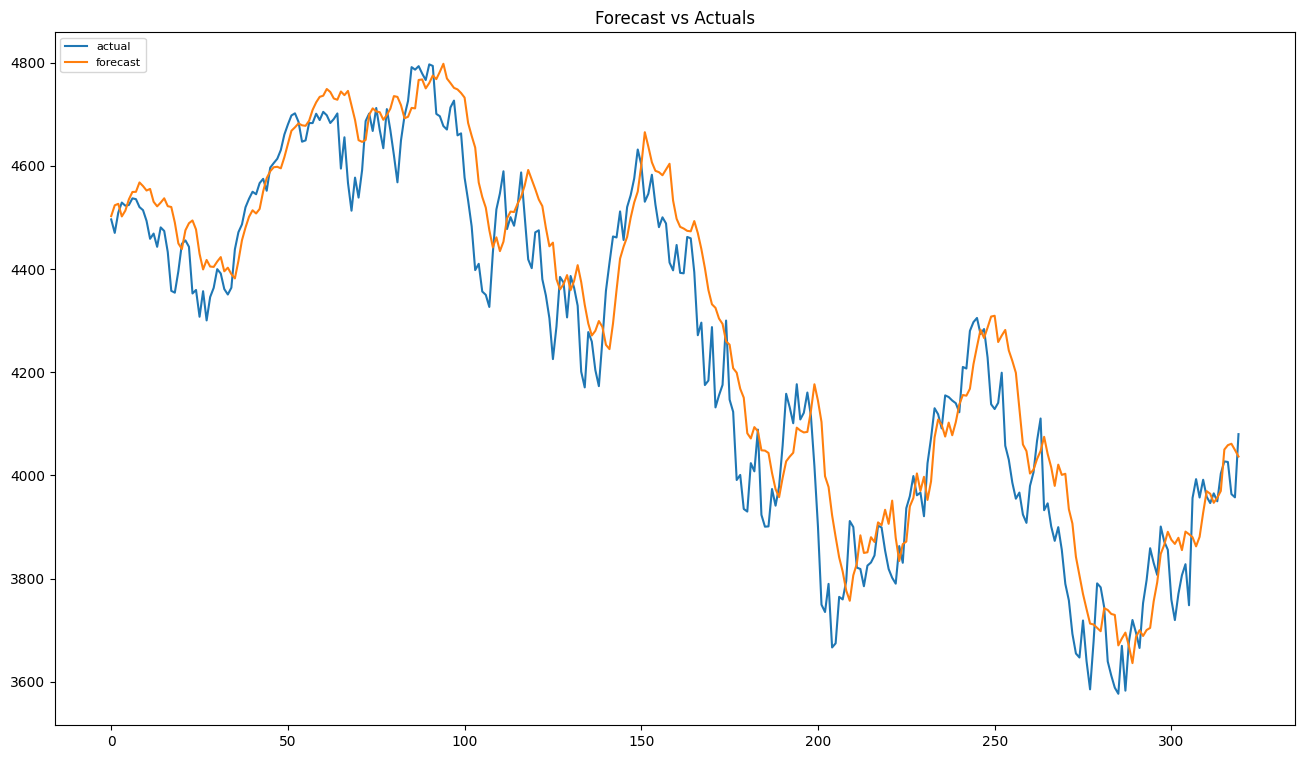

In [41]:
# Plot
plt.figure(figsize=(16, 9))
plt.plot(test_data, label='actual')
plt.plot(forecast_data, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)


In [42]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [43]:
print('model MSE :', mean_squared_error(test_data/100, forecast_data/100))
print('model MAE :', mean_absolute_error(test_data/100, forecast_data/100))
print('model MAPE :', mean_absolute_percentage_error(test_data, forecast_data))

model MSE : 1.0284414765113108
model MAE : 0.7965802893638612
model MAPE : 1.921935179188982
